In [2]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
# provider = IBMQ.load_account()
from qiskit import *
from qiskit.providers.ibmq import least_busy

In [3]:
# imports
import qiskit
import math

# imports
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# import qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_state_city

# gates/operators
from qiskit.quantum_info.operators import Operator

qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.2',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': None,
 'qiskit': '0.19.5'}

qiskit.__qiskit_version__

In [4]:
# CONVERSION TOOLS
def int_to_binary(i, length): # returns binary string of int with some length
    raw_str = "{0:b}".format(i)
    return raw_str.zfill(length)

def get_binary_basis_vec(d, n): # returns vec e_d from equation 2, string form
    # d is direction, n is number of dimensions/qubits
    e_d = ''.zfill(n - 1 - d) + '1' + ''.zfill(d)
    return e_d

def bitwise_xor(a, b): 
    # get bitwise addition/xor of two strings, length preserved
    y = int(a, 2)^int(b,2)
    return bin(y)[2:].zfill(len(a))

In [5]:
# VISUALIZATION TOOLS

def draw_circuit(self):
    return self.circuit.draw('mpl')

def plot_states_hist(self):  # plots by actually measuring the circuit
    self.circuit.measure_all()

    backend = Aer.get_backend('qasm_simulator')
    shots = 1024 # number of times circuit is run, for sampling
    results = execute(self.circuit, backend=backend, shots=shots).result()
    answer = results.get_counts()
  
    return plot_histogram(answer)

def plot_states_3D(self): # plots current states in 3D
    backend = Aer.get_backend('statevector_simulator') # the device to run on
    results = execute(self.circuit, backend).result()
    answer  = result.get_statevector(self.circuit)

    return plot_state_city(answer)

In [6]:
# CIRCUIT TOOLS
def get_n_qubits_coin(self):
    # number of qubits needed for the coin/
    # number of bits needed to specify direction in n-cube
    return int(math.ceil(np.log2(self.n)))
    
def initialize_circuit(self): # initializes quantum computer
    # need to initialize an equal superposition over all states
    self.n_qubits_coin = get_n_qubits_coin(self) # qubits needed for coin
    self.n_qubits_total = self.n + self.n_qubits_coin
    
    coin_register = QuantumRegister(self.n_qubits_coin, 'coin')
    cube_register = QuantumRegister(self.n, 'node')

    circuit = QuantumCircuit(coin_register, cube_register)

    for qubit in range(self.n_qubits_total):
        circuit.h(qubit) # perform hadamard on each qubit
    
    return circuit

In [83]:
# OPERATORS/GATES
def get_sC_matrix(self): # gets |s^C><s^C| matrix
    sC_matrix = np.ones((self.n, self.n)) / n
    
    return sC_matrix

def get_sC_operator(self):
    sC_matrix = get_sC_matrix(self)
    
    return Operator(sC_matrix)
    

def get_shift_matrix(self): # get matrix form of S operator
    S = np.zeros((self.dim_U, self.dim_U))
    
  # following equation 2 of the paper
    for d in range(self.n): # sum over each cartesian direction
        for x in range(self.N): # loop over each position on hypercube
            d_str = int_to_binary(d, self.n_qubits_coin)
            x_str = int_to_binary(x, self.n)
            e_d_str = get_binary_basis_vec(d, self.n)
            
#             print(d_str,x_str,e_d_str)

            # binary string that shows row:
            row_str = d_str + bitwise_xor(x_str, e_d_str)
            # same, for col:
            col_str = d_str + x_str
            
            row_index = int(row_str, 2)
            col_index = int(col_str, 2)
            
#             print(row_index, col_index)
            
            S[row_index][col_index] = 1
    
    return S


def get_shift_operator(self): # S operator, from the paper
    # get matrix from of the operator
    S_matrix = get_shift_matrix(self)

    return Operator(S_matrix)

def get_c_matrices(self): #C matrix
    grovers = np.full((self.n, self.n), 2/self.n)
    np.fill_diagonal(grovers, 2/self.n-1)
    coin_operator = np.kron(grovers, np.eye(self.N))
    return grovers, coin_operator

def get_coin_matrix(self):
    C_0, C = get_c_matrices(self)
    tens1 = -np.eye(self.n)- C_0
    tens2 = np.zeros((self.N,self.N)) # |000…00><000…00| term
    tens2[0][0] = 1
    
    right_term = np.kron(tens1, tens2)
    return C+right_term

def get_perturbed_coin_operator(self): # C' operator, from the paper
    coin_matrix = get_coin_matrix(self)
    return Operator(coin_matrix)

def get_perturbed_evolution_matrix(self): # U' matrix in the paper
    Cprime = get_coin_matrix(self)
    S = get_shift_matrix(self)
    return np.matmul(Cprime,S)
    
def get_perturbed_evolution_operator(self): # U' operator in the paper
    S = get_shift_operator(self)
    Cprime = get_perturbed_coin_operator(self)
    
    Uprime = S.compose(Cprime)
    
    return Uprime



In [63]:
class QRW:
    # INITIALIZATION HELPERS
    def __init__(self, num_qubits_cube):
        self.n = num_qubits_cube # total number of qubits in cube; n-cube will have N = 2^n nodes
        self.N = int(2**n)
        self.dim_U = self.n * int(2**n) # no. of rows/cols for U/S/C
        
        self.circuit = self.initialize_circuit()

    # CIRCUIT TOOLS
    initialize_circuit = initialize_circuit


    # VISUALIZATION TOOLS
    draw_circuit = draw_circuit
    plot_states_hist = plot_states_hist
    plot_states_3D = plot_states_3D

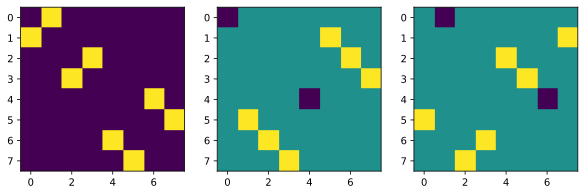

In [74]:
n = 2
qrw = QRW(n) # initialize computer
qrw.draw_circuit()
#qrw_instance.plot_states_hist()

fig, axes = plt.subplots(1,3,figsize=(10,10))

S = get_shift_matrix(qrw)
sC = get_sC_matrix(qrw)

axes[0].imshow(S)

cprime = get_coin_matrix(qrw)
axes[1].imshow(np.real(cprime.data))

Uprime = get_perturbed_evolution_operator(qrw)

axes[2].imshow(np.real(Uprime.data))
plt.show()

In [81]:
from qiskit.extensions import UnitaryGate
uprime = get_perturbed_evolution_operator(qrw)
uprime = UnitaryGate(uprime,label="U'")

In [84]:
qrw.unitary(uprime, [0,1,2])
draw_circuit(qrw)

AttributeError: 'QRW' object has no attribute 'unitary'

In [76]:
def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

In [71]:
uprime = get_perturbed_evolution_matrix(qrw)
is_unitary(np.matrix(uprime))

True

In [72]:
shift = get_shift_matrix(qrw)
is_unitary(np.matrix(shift))

True

In [9]:
n = 10
for d in range(n):
    print(get_binary_basis_vec(d, n))

0000000001
0000000010
0000000100
0000001000
0000010000
0000100000
0001000000
0010000000
0100000000
1000000000


In [54]:
grovers

array([[-0.75,  0.25,  0.25],
       [ 0.25, -0.75,  0.25],
       [ 0.25,  0.25, -0.75]])